<a href="https://colab.research.google.com/github/Sapienza-University-Rome/FedArtML/blob/master/examples/11_Get_started_create_FL_data_quantity_skew_dirichlet_Physionet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with FedArtML creating FL data (quantity skew) and implementing an FL model

Our ***FedArtML*** tool facilitates the generation of non-IID datasets
in a controlled way to support federated learning (FL) research for federated datasets from centralized datasets. It includes classes and functions to create federated datasets from centralized data, given the **number** of **clients** and the degree of heterogeneity (**non-IID-ness**) desired.

This guide aims to **understand** using the **SplitAsFederatedData** class to create federated datasets with the **Dirichlet method** for **Quantity skew**. We use the `Physionet 2020` dataset for our tests. Moreover, we include the `Flower framework` to train an FL model using the output from the FedArtML library.

**Notes:**
1. To check the source code, you can visit the [GitHub repo](https://github.com/Sapienza-University-Rome/FedArtML)
2. To check the documentation, you visit the [dedicated link](https://fedartml.readthedocs.io/en/latest/)

# Install libraries

First, installing the FedArtML and Flower libraries from Pypi (the latest version) is necessary.

In [ ]:
!pip install fedartml
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 11.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


# Import libraries

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

from io import BytesIO
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

import time
import pickle

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

from sklearn.impute import SimpleImputer

import plotly.graph_objects as go


# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

# Define parameters

Then it is necessary to define some parameters to run this notebook smoothly. The most important are:



*   `local_nodes_glob`: Defines the desired number of clients (local nodes) the centralized data will be divided into. In this case, we set it as 2.
*   `Alpha_quant`: Using the "Dirichlet-based" method, we need to define the `Alpha_quant`, which will determine the degree of heterogeneity of the client's distribution (non-IID-ness). Notice that the smaller the value of `Alpha_quant`, the higher the non-IID-ness. In this case, we set it as 1. Those parameters can be changed if desired to get familiar with their use.




In [ ]:
# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Define number of local nodes to be used
local_nodes_glob = 2

# Define Alpha for Dirichlet distribution to be used (quantity skew)
Alpha_quant = 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define functions

For the sake of order, we defined some functions that will be used in this guide.

In [ ]:
# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    logits = model.predict(X_test, batch_size=32, verbose=1, callbacks=[GarbageCollectorCallback()])
    y_pred = tf.argmax(logits, axis=1)
    loss = cce(Y_test, logits).numpy()
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

# Define Deep Neural Network (DNN) model
def DNN(shape,classes):
  initializer = tf.keras.initializers.GlorotUniform(seed = random_state)

  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu', input_shape=(shape,), kernel_initializer=initializer),
    tf.keras.layers.Dense(500, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dense(500, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dense(classes, activation='softmax')
    ])

  return model


# Define local training/evaluation function
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs_client) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.epochs_client = epochs_client

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, validation_split=0.1, epochs=self.epochs_client, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}

def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

# Load data

The centralized dataset to be employed is `Physionet 2020`, a high-quality 12-lead electrocardiography (ECG) data obtained from different health centres that use various ECG recording devices with varying levels of recording accuracy and observing different types of cardiac anomalies. Notice that we preproces the data as explained in our paper "[Application of federated learning techniques for arrhythmia classification using 12-lead ECG signals](https://arxiv.org/abs/2208.10993)" to get a tabular dataset. The preprocessed dataset is allocated in the GitHub of FedArtML.

In [ ]:
#Import curated data
df_selected_data = pd.read_csv('https://raw.githubusercontent.com/Sapienza-University-Rome/FedArtML/master/data/all_datasets_federated.csv', sep = ";")

# Get feature names
feature_names = [x for x in df_selected_data.columns if x not in ['db_name', 'label', 'id']]

# Preprocessing data

It is necessary to preprocess the data by getting the features and labels, scaling the data, splitting it randomly and encoding the labels to generate the model.

## Separate features and labels

In [ ]:
# Get features
features = df_selected_data.loc[:,df_selected_data.columns.isin(feature_names)]

# Get labels
labels = list(df_selected_data['label'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


## Scaling (normalizing) data

In [ ]:
# Replace NaN values with mean values
imputer = SimpleImputer().fit(features)
features = imputer.transform(features)

# Define min max scaler
scaler = RobustScaler()
# # Transform data
features = scaler.fit_transform(features).tolist()

## Split data (train, test)

In [ ]:
# Divide data in train test randomly, taking the train size as 90% of the whole data
x_train_glob, x_test_glob, y_train_glob, y_test_glob = train_test_split(features, labels, test_size = 0.1, random_state = random_state)

print("X Train shape:",pd.DataFrame(x_train_glob).shape)
print("Y Train shape:",pd.DataFrame(y_train_glob).shape)
print("X Test shape:",pd.DataFrame(x_test_glob).shape)
print("Y Test shape:",pd.DataFrame(y_test_glob).shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X Train shape: (37704, 120)
Y Train shape: (37704, 1)
X Test shape: (4190, 120)
Y Test shape: (4190, 1)


## Change string labels to numeric

In [ ]:
# Change categories by numbers (label encoding)
le = LabelEncoder()
le.fit(y_train_glob)
y_train_glob_num = le.transform(y_train_glob)
y_test_glob_num = le.transform(y_test_glob)

# Set number of local nodes
num_local_nodes = local_nodes_glob

# Create the federated dataset

This core function allows the creation of FL data from centralized data. The class `SplitAsFederatedData` is instantiated using a `random_state` to reproduce the results.

Then, the `.create_clients` function performs the federation of the centralized data by taking the features and labels, defining the number of desired clients and setting the Alpha_quant value.

Then, the output of `.create_clients` is:

`clients_glob_dic`: Contains features (images) and labels for each local node (client) after creating the federated data. It includes "with_class_completion" and "without_class_completion" cases.

`list_ids_sampled_dic` : Indexes of examples (partition) taken for each local node (client).

`miss_class_per_node` : Number of missing classes per each local node when creating the federated dataset

`distances`: Distances calculated while measuring heterogeneity (non-IID-ness) of distribution among clients. It includes "with_class_completion" and "without_class_completion" cases.


**Note:** When creating federated data and setting heterogeneous distributions (i.e. high values of percent_noniid or small values of Alpha), it is more likely the clients hold examples from only one class. Then, two cases are returned as output for fed_data and distances:
- "with_class_completion": In this case, the clients are completed with one (random) example of each missing class for each client to have all the label's classes.
- "without_class_completion": In this case, the clients are NOT completed with one (random) example of each missing class. Consequently, summing the number of examples of each client results in the same number of total examples (number of rows in image_list).

In addition, the function `from_FedArtML_to_Flower_format` is employed to take the output of the `.create_clients` function into a list (list of tensors/numpy arrays) that can be easily plugged into the Flower framework.

In [ ]:
# Instantiate a SplitAsFederatedData object
my_federater = SplitAsFederatedData(random_state = random_state)

# Get federated dataset from centralized dataset
clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(image_list = x_train_glob, label_list = y_train_glob_num,
                                                             num_clients = local_nodes_glob, prefix_cli='Local_node',
                                                         method = "no-label-skew", quant_skew_method="dirichlet", alpha_quant_split=Alpha_quant)

clients_glob = clients_glob_dic['without_class_completion']
list_ids_sampled = list_ids_sampled_dic['without_class_completion']

# Convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In the following part, we show the label's distribution for the two clients selected with a non-IID-ness of Alpha_quant=1. Notice that it is printed the number of examples and the percentage of participation per each client .

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[11338, 26366]
[0.3007107999151284, 0.6992892000848716]


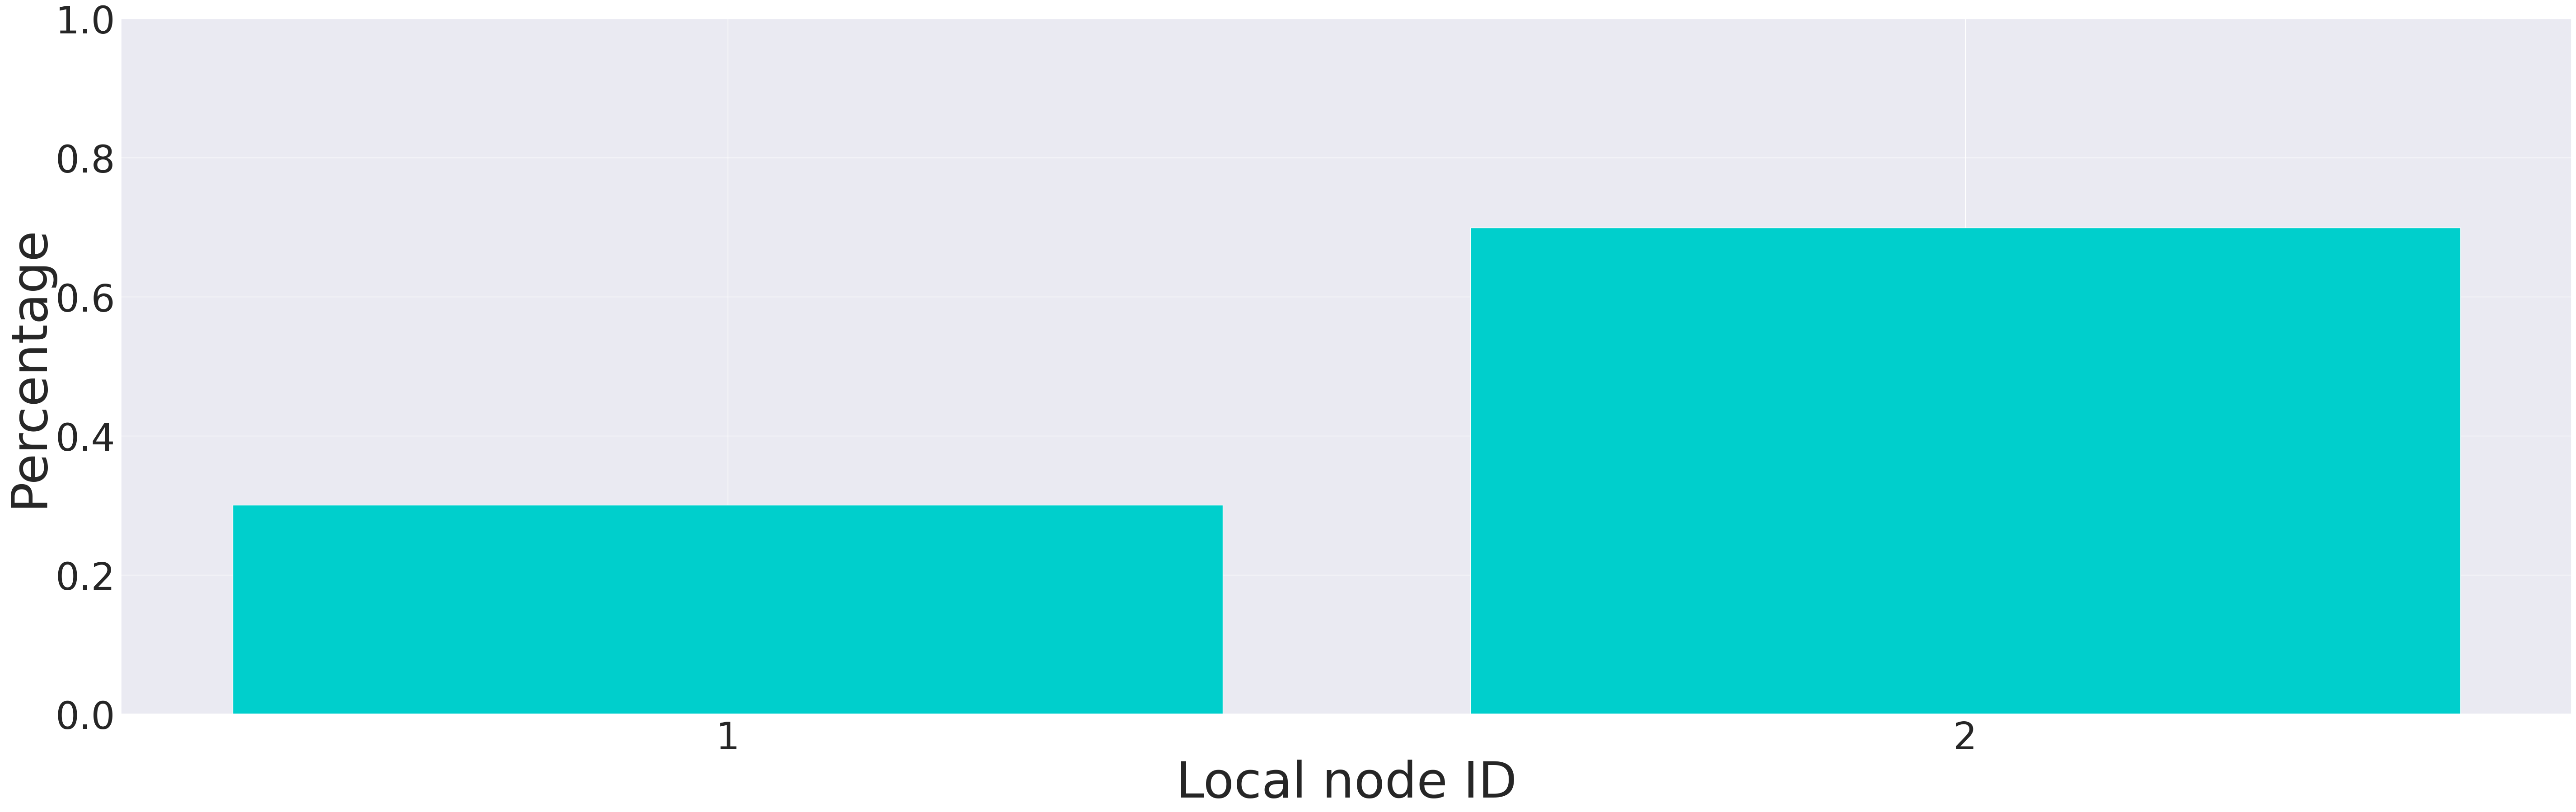

In [ ]:
## Check IID properties
# Define dimensions for plot
sizes = [len(value) for key, value in clients_glob.items()]
local_nodes_name = [key[-1] for key, value in clients_glob.items()]
prop = [value/sum(sizes) for value in sizes]

print(sizes)
print(prop)

plt.figure(figsize=(70,20))
plt.bar(local_nodes_name, prop,alpha = 1, color=colors[0])
plt.xlabel('Local node ID', fontsize=80)
plt.ylabel('Percentage', fontsize=80)
plt.title("", fontsize=100)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.ylim([0,1])
plt.show()

Moreover, the tool automatically calculates the distances to measure how different the distributions among the clients are.

In [ ]:
# Calculate distances
JSD_glob_quant = distances['without_class_completion_quant']['jensen-shannon']
print("Jensen-Shannon distance:", JSD_glob_quant)
HD_glob_quant = distances['without_class_completion_quant']['hellinger']
print("Hellinger distance:", HD_glob_quant)
EMD_glob_quant = distances['without_class_completion_quant']['earth-movers']
print("Earth Mover’s distance:", EMD_glob_quant)

Jensen-Shannon distance: 0.24273644044461617
Hellinger distance: 0.2035506516939111
Earth Mover’s distance: 0.6313306583477023


Notice that FedArtML automatically calculates the metrics for the label skew, generated by the feature skew partition.

In [ ]:
# Calculate distances
JSD_glob = distances['without_class_completion']['jensen-shannon']
print("Jensen-Shannon distance:", JSD_glob)
HD_glob = distances['without_class_completion']['hellinger']
print("Hellinger distance:", HD_glob)
EMD_glob = distances['without_class_completion']['earth-movers']
print("Earth Mover’s distance:", EMD_glob)

Jensen-Shannon distance: 0.025495577135721006
Hellinger distance: 0.021229461826417082
Earth Mover’s distance: 0.038611005968250026


# Train with Deep Neural Network (DNN)

Up to this point, we have shown how to use the **FedArtML** to create a federated dataset starting from centralized data. Then, we introduce the code to train an FL model using the **Flower framework**.

In [ ]:
# Define loss
loss_inic = SparseCategoricalCrossentropy()

# Define metric to check
metrics = SparseCategoricalAccuracy()

In [ ]:
# The `evaluate` function will be by Flower called after every round
def evaluate_DNN_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = DNN(len(feature_names), len(np.unique(labels)))
    net.set_weights(parameters) # Update model with the latest parameters
    loss, accuracy, precision, recall, f1score  = test_model(net, x_test_glob, np.array(y_test_glob_num))
    print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} / f1score {f1score} @@@@@@")
    return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

In the following cell, notice that the `client_fn` function takes the features (`list_x_train`) and labels (`list_y_train`) lists created from the **FedArtML** library to select the data used for each client.

In [ ]:
# Define number of epochs per local node
epochs = 2

# Define number of communication rounds
comms_round = 5


# Define dunction to pass to each local node (client)
def client_fn(cid: str) -> fl.client.Client:
    # Define model
    model = DNN(len(feature_names), len(np.unique(labels)))

    # Set optimizer
    optimizer = Adam(learning_rate=0.001)

    # Compile model
    model.compile(optimizer=optimizer,loss=loss_inic,metrics=metrics)

    # Load data partition of each client ID (cid)
    x_train_cid = np.array(list_x_train[int(cid)],dtype=float)
    y_train_cid = np.array(list_y_train[int(cid)],dtype=float)

    # Define test data (taken from the centralized data to compare performance of CL and FL)
    x_test_cid = np.array(x_test_glob)
    y_test_cid = np.array(y_test_glob_num)

    # Create and return client
    return FlowerClient(model, x_train_cid, y_train_cid, x_test_cid, y_test_cid, epochs)

# Create Federated strategy
strategy=fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=local_nodes_glob,  # Never sample less than 2 clients for training
        min_evaluate_clients=local_nodes_glob//2,  # Never sample less than 1 client for evaluation
        min_available_clients=local_nodes_glob,  # Wait until all clients are available
        evaluate_fn=evaluate_DNN_CL
)

start_time = time.time()
# Start simulation (training FL)
commun_metrics_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=local_nodes_glob,
    config=fl.server.ServerConfig(num_rounds=comms_round),
    strategy=strategy,
)

# Get total training time
training_time = time.time() - start_time

# Unmask metrics
global_acc_test = retrieve_global_metrics(commun_metrics_history,"centralized","accuracy",False)

global_pre_test = retrieve_global_metrics(commun_metrics_history,"centralized","precision",False)

global_rec_test = retrieve_global_metrics(commun_metrics_history,"centralized","recall",False)

global_f1s_test = retrieve_global_metrics(commun_metrics_history,"centralized","f1score",False)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")
print('Test: commun_round: {} | global_acc: {:} | global_pre: {} | global_rec: {} | global_f1s: {}'.format(comms_round, global_acc_test, global_pre_test, global_rec_test, global_f1s_test))
print("Training time: %s seconds" % (training_time))

INFO flwr 2024-03-08 15:15:02,825 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-03-08 15:15:07,447	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-08 15:15:09,809 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3932263219.0, 'memory': 7864526439.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3932263219.0, 'memory': 7864526439.0}
INFO flwr 2024-03-08 15:15:09,820 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-08 15:

131/131 [==============================] - 0s 2ms/step


INFO flwr 2024-03-08 15:15:26,226 | server.py:94 | initial parameters (loss, other metrics): 3.9697592, {'accuracy': 0.04343675417661098, 'precision': 0.2849181498586196, 'recall': 0.04343675417661098, 'f1score': 0.06844886576881495}
INFO:flwr:initial parameters (loss, other metrics): 3.9697592, {'accuracy': 0.04343675417661098, 'precision': 0.2849181498586196, 'recall': 0.04343675417661098, 'f1score': 0.06844886576881495}
INFO flwr 2024-03-08 15:15:26,230 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-03-08 15:15:26,233 | server.py:222 | fit_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 1: strategy sampled 2 clients (out of 2)


@@@@@@ Server-side evaluation loss 3.969759225845337 / accuracy 0.04343675417661098 / f1score 0.06844886576881495 @@@@@@
(DefaultActor pid=1235) Epoch 1/2
(DefaultActor pid=1235) 319/319 - 4s - loss: 208.6079 - sparse_categorical_accuracy: 0.3599 - val_loss: 49.2723 - val_sparse_categorical_accuracy: 0.3898 - 4s/epoch - 12ms/step
(DefaultActor pid=1235) 319/319 - 3s - loss: 21.6228 - sparse_categorical_accuracy: 0.4398 - val_loss: 15.5560 - val_sparse_categorical_accuracy: 0.4418 - 3s/epoch - 9ms/step
(DefaultActor pid=1235) Epoch 2/2 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


DEBUG flwr 2024-03-08 15:15:37,867 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
WARNING flwr 2024-03-08 15:15:37,875 | fedavg.py:250 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=1234) 742/742 - 4s - loss: 11.6359 - sparse_categorical_accuracy: 0.4677 - val_loss: 3.1874 - val_sparse_categorical_accuracy: 0.4854 - 4s/epoch - 5ms/step [repeated 2x across cluster]
131/131 [==============================] - 0s 2ms/step


INFO flwr 2024-03-08 15:15:39,470 | server.py:125 | fit progress: (1, 1.8673939, {'accuracy': 0.45202863961813844, 'precision': 0.6745716259044788, 'recall': 0.45202863961813844, 'f1score': 0.5182292169857807}, 13.236974275000023)
INFO:flwr:fit progress: (1, 1.8673939, {'accuracy': 0.45202863961813844, 'precision': 0.6745716259044788, 'recall': 0.45202863961813844, 'f1score': 0.5182292169857807}, 13.236974275000023)
DEBUG flwr 2024-03-08 15:15:39,473 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 2)


@@@@@@ Server-side evaluation loss 1.8673938512802124 / accuracy 0.45202863961813844 / f1score 0.5182292169857807 @@@@@@


DEBUG flwr 2024-03-08 15:15:39,933 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2024-03-08 15:15:39,936 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-03-08 15:15:39,938 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=1234) 131/131 - 0s - loss: 3.4730 - sparse_categorical_accuracy: 0.4520 - 274ms/epoch - 2ms/step
(DefaultActor pid=1234) Epoch 2/2
(DefaultActor pid=1234) Epoch 1/2
(DefaultActor pid=1234) 319/319 - 4s - loss: 14.5897 - sparse_categorical_accuracy: 0.4549 - val_loss: 2.1309 - val_sparse_categorical_accuracy: 0.4744 - 4s/epoch - 12ms/step
(DefaultActor pid=1234) 319/319 - 3s - loss: 9.6145 - sparse_categorical_accuracy: 0.4929 - val_loss: 7.8872 - val_sparse_categorical_accuracy: 0.4762 - 3s/epoch - 9ms/step
(DefaultActor pid=1234) Epoch 2/2 [repeated 2x across cluster]


DEBUG flwr 2024-03-08 15:15:51,477 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures


131/131 [==============================] - 0s 2ms/step


INFO flwr 2024-03-08 15:15:53,123 | server.py:125 | fit progress: (2, 1.6229173, {'accuracy': 0.5105011933174224, 'precision': 0.6031305387575396, 'recall': 0.5105011933174224, 'f1score': 0.546523629371982}, 26.88956675899999)
INFO:flwr:fit progress: (2, 1.6229173, {'accuracy': 0.5105011933174224, 'precision': 0.6031305387575396, 'recall': 0.5105011933174224, 'f1score': 0.546523629371982}, 26.88956675899999)
DEBUG flwr 2024-03-08 15:15:53,129 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 2)


@@@@@@ Server-side evaluation loss 1.6229172945022583 / accuracy 0.5105011933174224 / f1score 0.546523629371982 @@@@@@


DEBUG flwr 2024-03-08 15:15:53,601 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2024-03-08 15:15:53,604 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)


(DefaultActor pid=1235) 131/131 - 0s - loss: 1.7099 - sparse_categorical_accuracy: 0.5105 - 288ms/epoch - 2ms/step
(DefaultActor pid=1235) 742/742 - 4s - loss: 3.2278 - sparse_categorical_accuracy: 0.5032 - val_loss: 1.6757 - val_sparse_categorical_accuracy: 0.5002 - 4s/epoch - 5ms/step [repeated 2x across cluster]
(DefaultActor pid=1235) Epoch 2/2
(DefaultActor pid=1235) Epoch 1/2
(DefaultActor pid=1235) 319/319 - 4s - loss: 4.7783 - sparse_categorical_accuracy: 0.5309 - val_loss: 2.6527 - val_sparse_categorical_accuracy: 0.4974 - 4s/epoch - 11ms/step [repeated 2x across cluster]
(DefaultActor pid=1235) Epoch 2/2 [repeated 2x across cluster]


DEBUG flwr 2024-03-08 15:16:05,288 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures


131/131 [==============================] - 0s 2ms/step


INFO flwr 2024-03-08 15:16:06,879 | server.py:125 | fit progress: (3, 1.6391156, {'accuracy': 0.4983293556085919, 'precision': 0.5642210460597615, 'recall': 0.4983293556085919, 'f1score': 0.5238312902013195}, 40.64593627400001)
INFO:flwr:fit progress: (3, 1.6391156, {'accuracy': 0.4983293556085919, 'precision': 0.5642210460597615, 'recall': 0.4983293556085919, 'f1score': 0.5238312902013195}, 40.64593627400001)


@@@@@@ Server-side evaluation loss 1.639115571975708 / accuracy 0.4983293556085919 / f1score 0.5238312902013195 @@@@@@


DEBUG flwr 2024-03-08 15:16:06,883 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 2)
DEBUG flwr 2024-03-08 15:16:07,349 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2024-03-08 15:16:07,353 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)


(DefaultActor pid=1234) 131/131 - 0s - loss: 2.0667 - sparse_categorical_accuracy: 0.4983 - 284ms/epoch - 2ms/step
(DefaultActor pid=1234) 742/742 - 3s - loss: 3.1117 - sparse_categorical_accuracy: 0.5319 - val_loss: 2.4518 - val_sparse_categorical_accuracy: 0.5021 - 3s/epoch - 4ms/step [repeated 2x across cluster]
(DefaultActor pid=1234) Epoch 2/2
(DefaultActor pid=1234) Epoch 1/2
(DefaultActor pid=1234) 319/319 - 5s - loss: 3.8694 - sparse_categorical_accuracy: 0.5149 - val_loss: 2.1457 - val_sparse_categorical_accuracy: 0.5097 - 5s/epoch - 16ms/step
(DefaultActor pid=1234) Epoch 2/2 [repeated 2x across cluster]
(DefaultActor pid=1234) 319/319 - 3s - loss: 3.7748 - sparse_categorical_accuracy: 0.5546 - val_loss: 3.6269 - val_sparse_categorical_accuracy: 0.4947 - 3s/epoch - 9ms/step


DEBUG flwr 2024-03-08 15:16:19,805 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures


(DefaultActor pid=1235) Epoch 2/2
131/131 [==============================] - 0s 2ms/step


INFO flwr 2024-03-08 15:16:21,807 | server.py:125 | fit progress: (4, 1.6187954, {'accuracy': 0.51527446300716, 'precision': 0.5691680894066903, 'recall': 0.51527446300716, 'f1score': 0.5351890899606924}, 55.57369886700002)
INFO:flwr:fit progress: (4, 1.6187954, {'accuracy': 0.51527446300716, 'precision': 0.5691680894066903, 'recall': 0.51527446300716, 'f1score': 0.5351890899606924}, 55.57369886700002)
DEBUG flwr 2024-03-08 15:16:21,811 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 2)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 2)


@@@@@@ Server-side evaluation loss 1.618795394897461 / accuracy 0.51527446300716 / f1score 0.5351890899606924 @@@@@@


DEBUG flwr 2024-03-08 15:16:22,537 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2024-03-08 15:16:22,539 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)


(DefaultActor pid=1235) 131/131 - 0s - loss: 1.8556 - sparse_categorical_accuracy: 0.5153 - 302ms/epoch - 2ms/step
(DefaultActor pid=1235) 742/742 - 4s - loss: 4.5207 - sparse_categorical_accuracy: 0.5723 - val_loss: 2.0016 - val_sparse_categorical_accuracy: 0.5154 - 4s/epoch - 6ms/step [repeated 2x across cluster]
(DefaultActor pid=1235) Epoch 1/2
(DefaultActor pid=1235) 319/319 - 5s - loss: 2.1618 - sparse_categorical_accuracy: 0.5276 - val_loss: 2.6373 - val_sparse_categorical_accuracy: 0.5079 - 5s/epoch - 16ms/step
(DefaultActor pid=1235) 319/319 - 3s - loss: 4.9100 - sparse_categorical_accuracy: 0.5809 - val_loss: 2.0134 - val_sparse_categorical_accuracy: 0.5159 - 3s/epoch - 9ms/step
(DefaultActor pid=1235) Epoch 2/2 [repeated 2x across cluster]


DEBUG flwr 2024-03-08 15:16:34,177 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG:flwr:fit_round 5 received 2 results and 0 failures


131/131 [==============================] - 0s 3ms/step


INFO flwr 2024-03-08 15:16:36,209 | server.py:125 | fit progress: (5, 1.6726794, {'accuracy': 0.49594272076372314, 'precision': 0.5596182581822349, 'recall': 0.49594272076372314, 'f1score': 0.5189693892171116}, 69.975543125)
INFO:flwr:fit progress: (5, 1.6726794, {'accuracy': 0.49594272076372314, 'precision': 0.5596182581822349, 'recall': 0.49594272076372314, 'f1score': 0.5189693892171116}, 69.975543125)
DEBUG flwr 2024-03-08 15:16:36,215 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 2)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 2)


@@@@@@ Server-side evaluation loss 1.6726794242858887 / accuracy 0.49594272076372314 / f1score 0.5189693892171116 @@@@@@


DEBUG flwr 2024-03-08 15:16:36,839 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
INFO flwr 2024-03-08 15:16:36,842 | server.py:153 | FL finished in 70.609129472
INFO:flwr:FL finished in 70.609129472
INFO flwr 2024-03-08 15:16:36,844 | app.py:226 | app_fit: losses_distributed [(1, 3.4730374813079834), (2, 1.7098515033721924), (3, 2.0667471885681152), (4, 1.8555887937545776), (5, 1.6732324361801147)]
INFO:flwr:app_fit: losses_distributed [(1, 3.4730374813079834), (2, 1.7098515033721924), (3, 2.0667471885681152), (4, 1.8555887937545776), (5, 1.6732324361801147)]
INFO flwr 2024-03-08 15:16:36,845 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2024-03-08 15:16:36,847 | app.py:228 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2024-03-08 15:16:36,848 | app.py:229 | app_fit: losses_centralized [(0, 3.9697592), (



FINAL RESULTS: ===========================================================================================================================================================================================
Test: commun_round: 5 | global_acc: 0.49594272076372314 | global_pre: 0.5596182581822349 | global_rec: 0.49594272076372314 | global_f1s: 0.5189693892171116
Training time: 94.04759955406189 seconds
(DefaultActor pid=1234) 131/131 - 0s - loss: 1.6732 - sparse_categorical_accuracy: 0.4959 - 351ms/epoch - 3ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


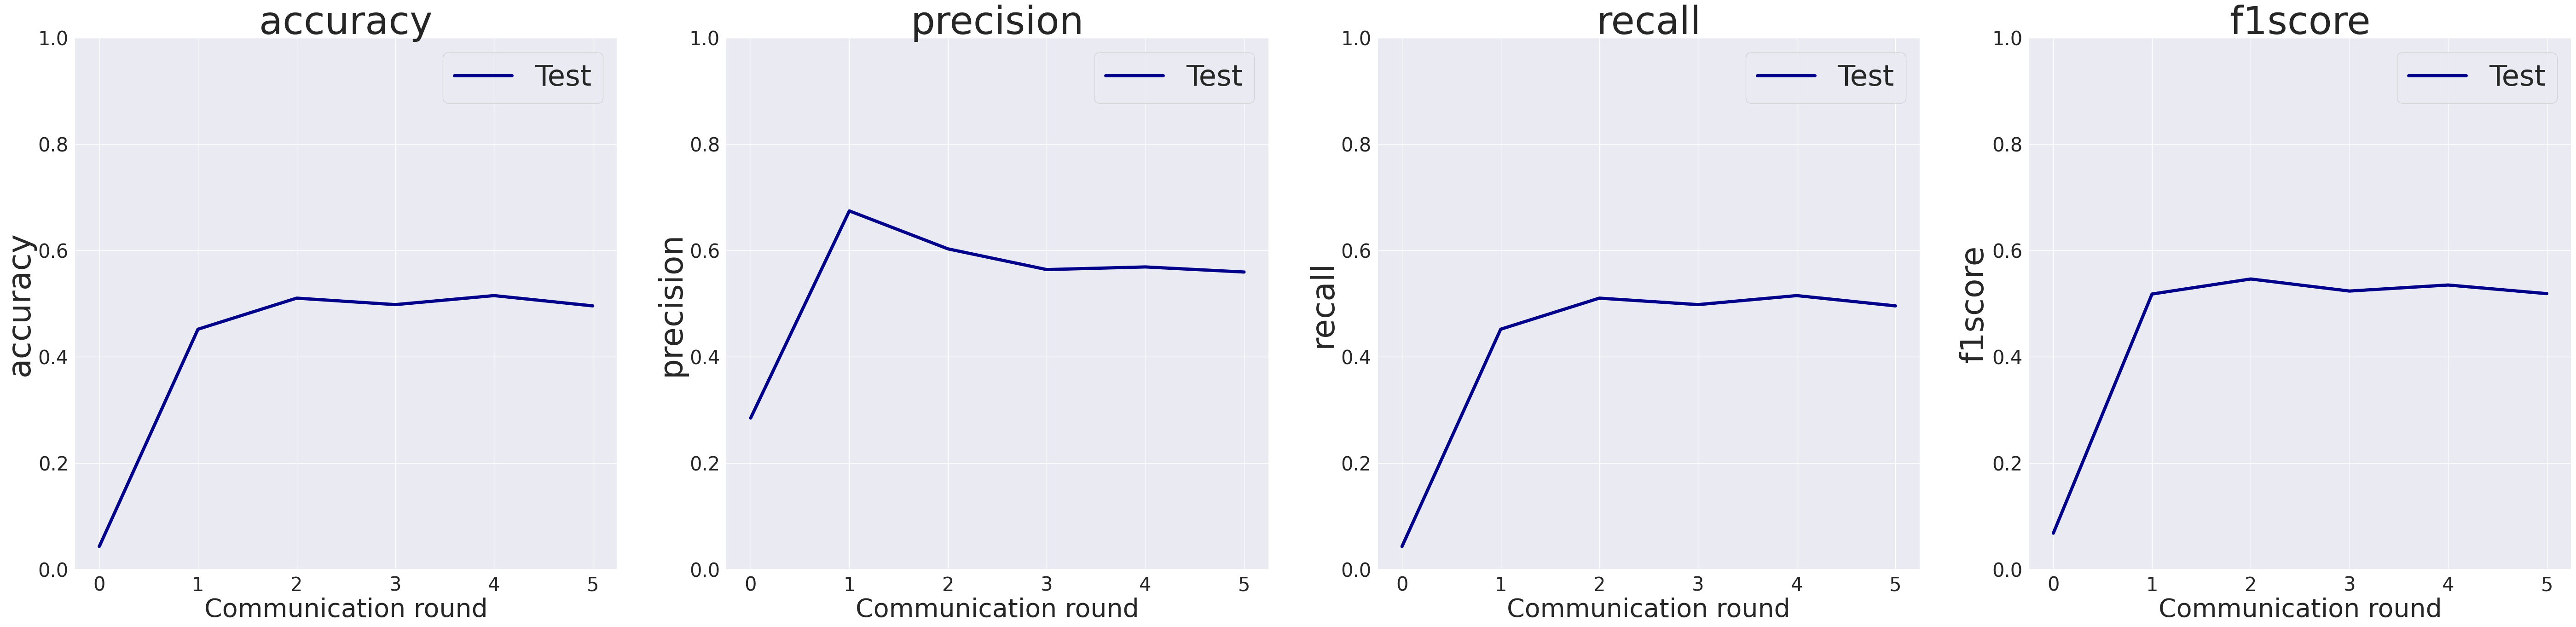

In [ ]:
# Define metrics to plot
metrics_show = ["accuracy","precision","recall","f1score"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(70,15))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(commun_metrics_history,"any","centralized",metrics_show[i])

In [ ]:
# Define metrics in a dataframe
metrics_DNN = {'metric_name':  ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
           'set_used': ['Test', 'Test', 'Test', 'Test'],
           'metric_value': [ global_acc_test , global_pre_test , global_rec_test , global_f1s_test]
        }

metrics_DNN = pd.DataFrame(metrics_DNN, columns = ['metric_name', 'set_used','metric_value'])

# Plot metrics
fig = go.Figure(data=[
    go.Bar(name='Test', x=metrics_DNN[metrics_DNN['set_used']=="Test"]['metric_name'], y=metrics_DNN[metrics_DNN['set_used']=="Test"]['metric_value'], marker_color=colors[4])
], layout_yaxis_range=[0,1])
# Change the bar mode
fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Metric",
    yaxis_title="Metric value",
    legend_title="Dataset", font=dict(size=20)
    )


fig.show()